In [20]:
import csv
import os
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc

# Create model with no observed data

In [2]:
with pm.Model() as model:

    temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
    temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
    temp_std = pm.HalfNormal("temp_std", 1, shape=3)
    temp_posterior = pm.NormalMixture(
        "temp_posterior", 
        temp_mw, 
        temp_prior, 
        temp_std
    )
    precip_prior = pm.HalfNormal("precip_prior", 1)
    precip_posterior = pm.Exponential("precip_posterior", precip_prior)
    drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
    drought_likelihood_coefs = pm.Deterministic(
        "drought_likelihood_coefs", 
        pt.transpose(
            pm.math.stack(
                [
                     (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                     (drought_coefs[1] * np.ones(1)) + (drought_coefs[3] * np.ones(1))
                ]
            )
        )
    )
    drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
    drought_posterior = pm.Categorical("drought_posterior", drought_prior)
    temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
    temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
    precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
    precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
    drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    tfp_prior = pm.Deterministic(
        "tfp_prior",
        tfp_intercept +
        (temp_tfp_coef * temp_posterior) +
        (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
        (precip_tfp_coef * precip_posterior) +
        (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
        (drought_tfp_coef * drought_posterior)
    )
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)

In [3]:
set_values = {
    "temp_mixture_weights" : [1,1,1],
    "temp_prior" : [[0,0,0]],
    "temp_std" : [1,1,1],
    "precip_prior" : 1,
    "drought_coefs" : [0,0,0,0],
    "temp_tfp_coef" : 0,
    "temp_tfp_coef2" : 0,
    "precip_tfp_coef" : 0,
    "precip_tfp_coef2" : 0,
    "drought_tfp_coef" : -10,
    "tfp_intercept" : 0
}
model_simulate = do(model, set_values)

In [85]:
with model_simulate:
    simulate = pm.sample_prior_predictive(10000)
    observed = {
        "temp": simulate.prior["temp_posterior"].values.flatten(),
        "precip": simulate.prior["precip_posterior"].values.flatten(),
        "drought": simulate.prior["drought_posterior"].values.flatten(),
        "tfp": simulate.prior["tfp_posterior"].values.flatten()
    }
    df = pd.DataFrame(observed).sort_values("temp", ascending=False)

Sampling: [drought_posterior, precip_posterior, temp_posterior, tfp_posterior, tfp_std]


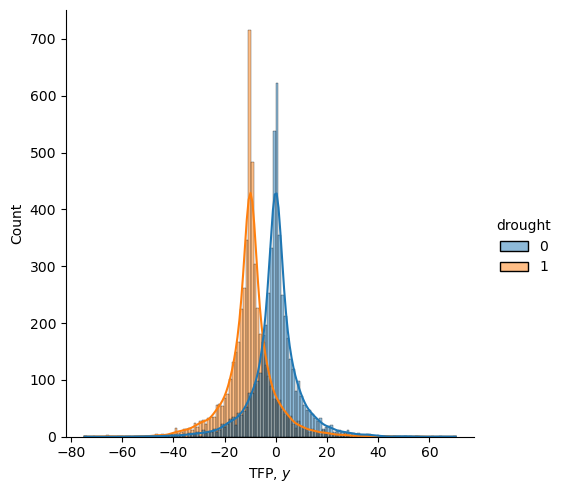

In [86]:
ax = sns.displot(data=df, x="tfp", hue="drought", kde=True)
ax.set(xlabel="TFP, $y$");

In [87]:
with pm.Model() as model:

    temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
    temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
    temp_std = pm.HalfNormal("temp_std", 1, shape=3)
    temp_posterior = pm.NormalMixture(
        "temp_posterior", 
        temp_mw, 
        temp_prior, 
        temp_std,
        observed=df["temp"]
    )
    precip_prior = pm.HalfNormal("precip_prior", 1)
    precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=df["precip"])
    drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
    drought_likelihood_coefs = pm.Deterministic(
        "drought_likelihood_coefs", 
        pt.transpose(
            pm.math.stack(
                [
                     (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                     (drought_coefs[1] * np.ones(len(df["temp"]))) + (drought_coefs[3] * np.ones(len(df["temp"])))
                ]
            )
        )
    )
    drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
    drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=df["drought"])
    temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
    temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
    precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
    precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
    drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    tfp_prior = pm.Deterministic(
        "tfp_prior",
        tfp_intercept +
        (temp_tfp_coef * temp_posterior) +
        (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
        (precip_tfp_coef * precip_posterior) +
        (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
        (drought_tfp_coef * drought_posterior)
    )
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=df["tfp"])

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temp_mixture_weights, temp_prior, temp_std, precip_prior, drought_coefs, temp_tfp_coef, temp_tfp_coef2, precip_tfp_coef, precip_tfp_coef2, drought_tfp_coef, tfp_intercept, tfp_std]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 1394 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


# Parameter recovery to check model validity

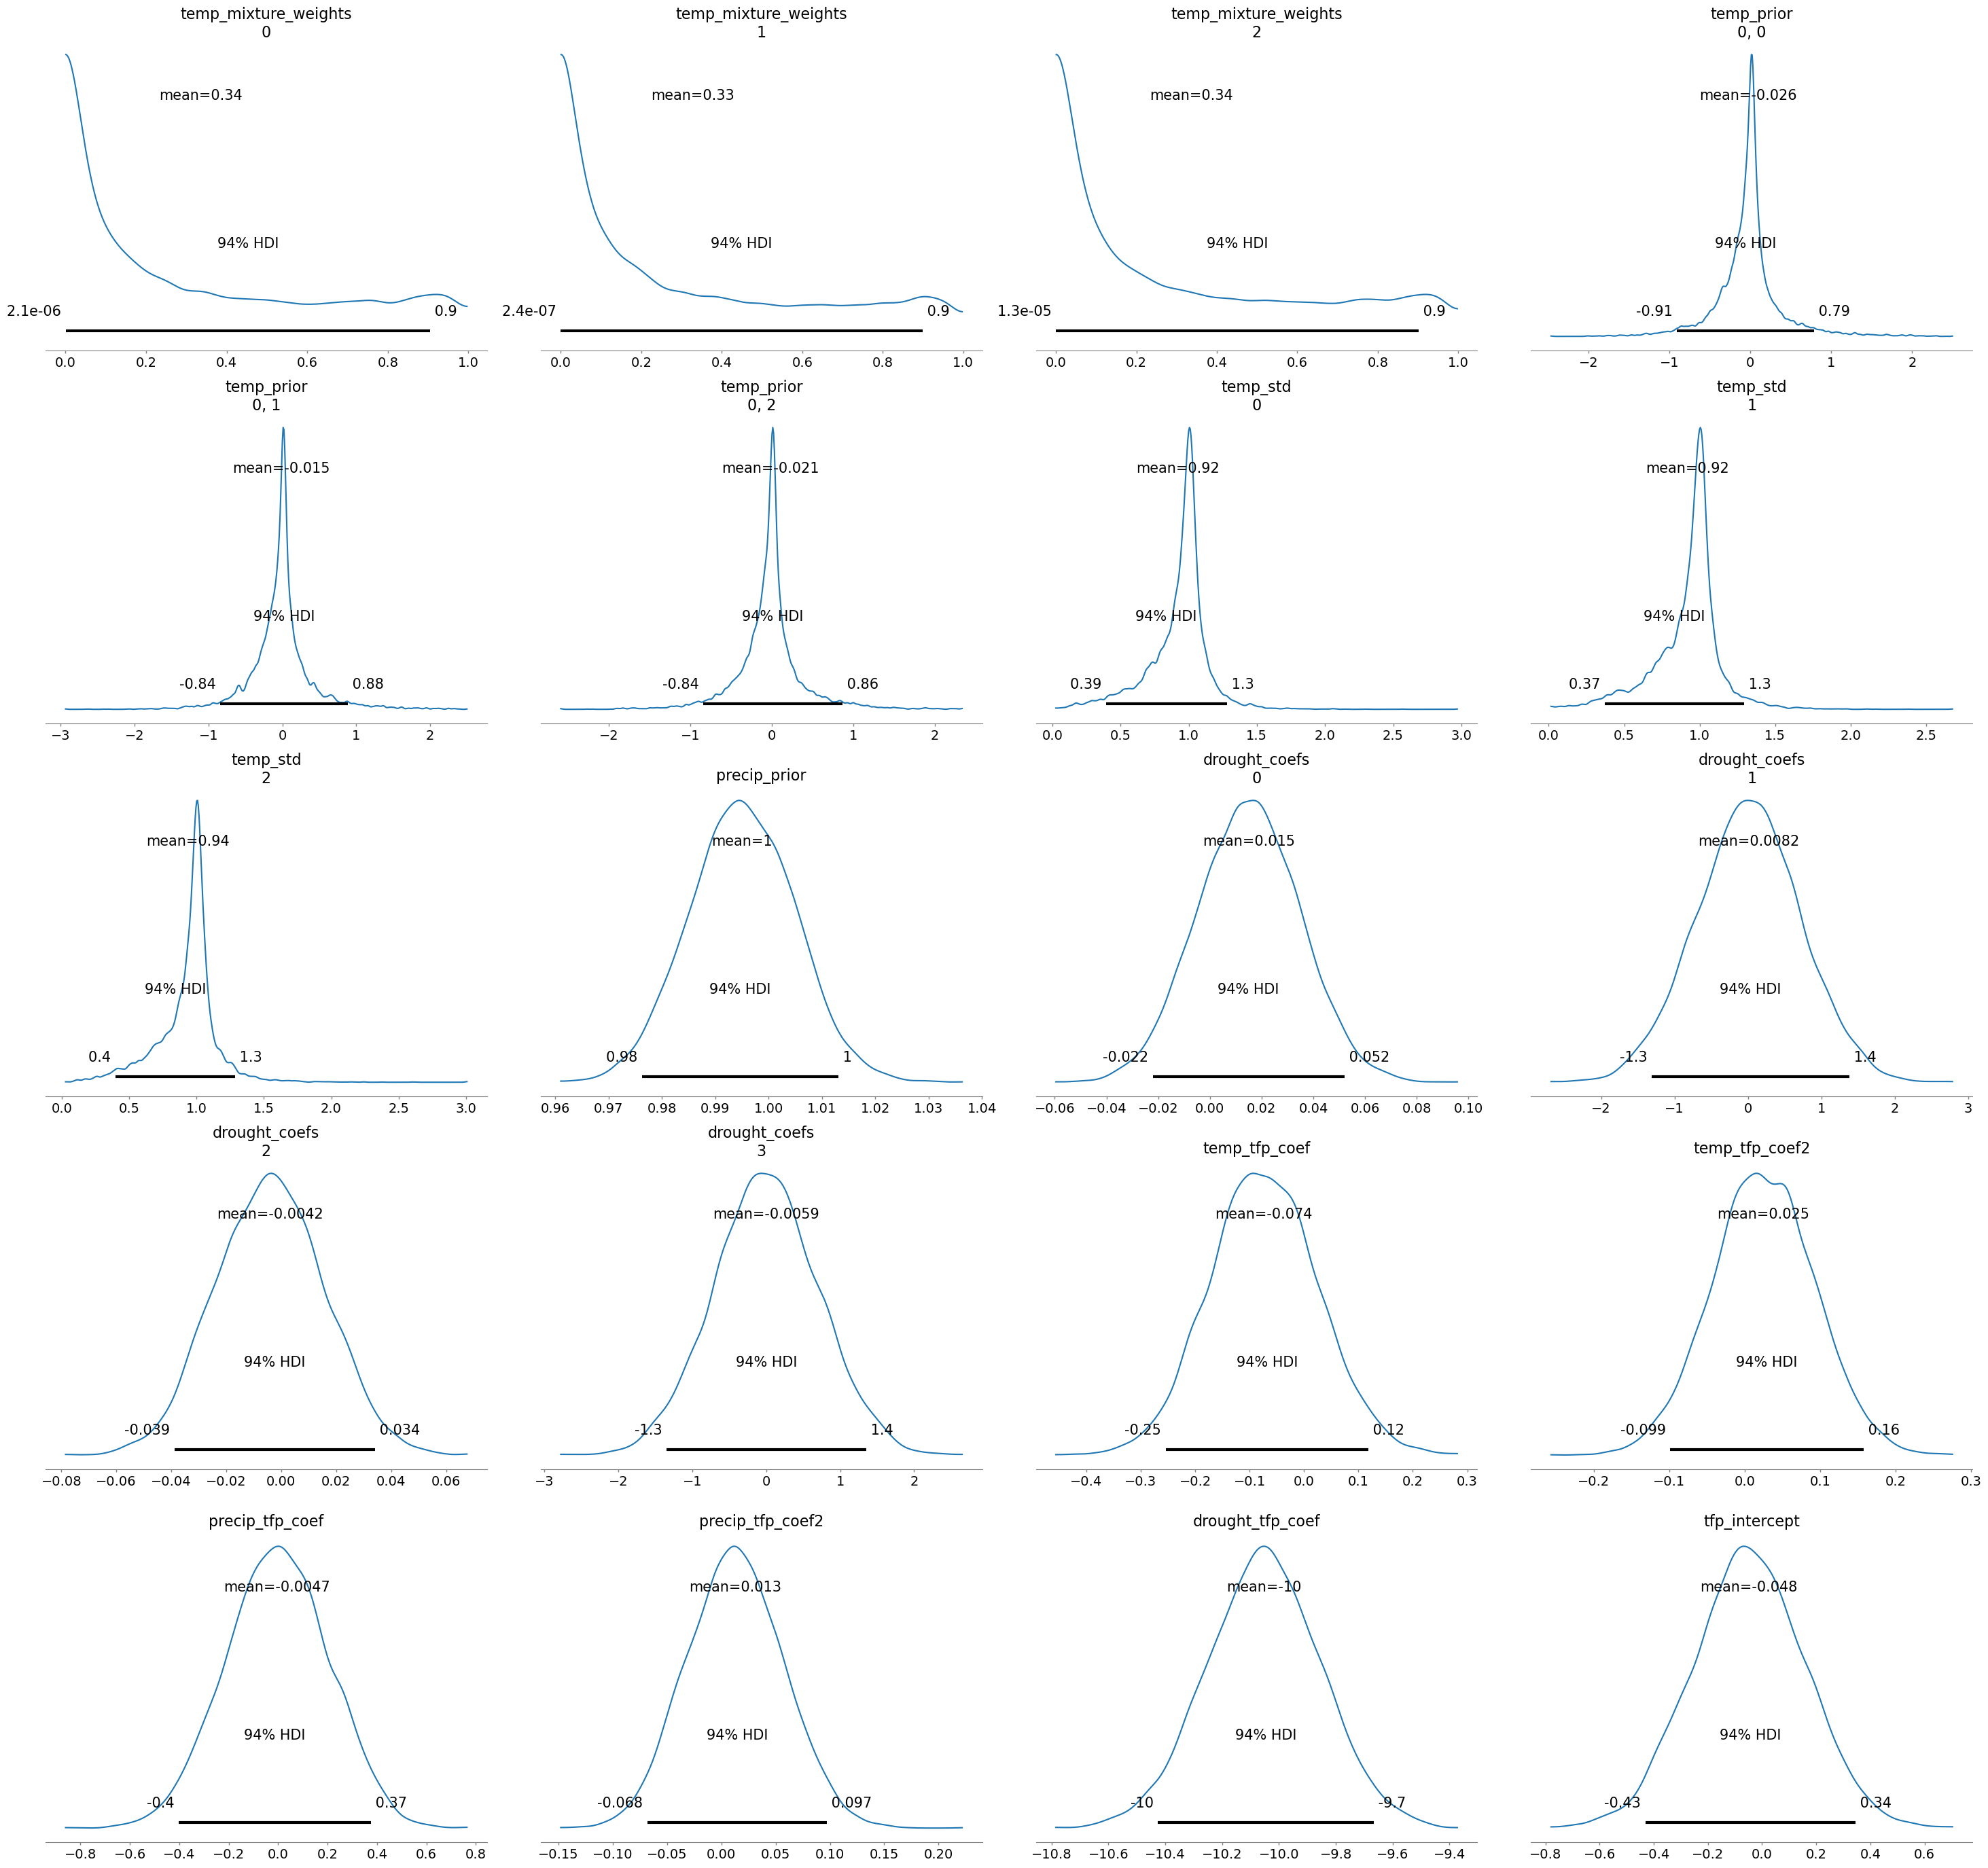

In [88]:
keys = list(set_values.keys())
az.plot_posterior(
    idata,
    var_names=keys,
)
plt.tight_layout();

# Regional Effect of Drought on TFP

## How much does drought effect tfp in each region? (Average Treatment Effect)

In [17]:
integrated_data = pd.read_csv("../data/processed/five_node_model_integrated_data.csv")
countries_by_region = {}
data_by_country = {}
data_by_region = {}
for country in set(integrated_data["Country"]):
    region = cc.convert(country, to="UNregion")
    if region not in countries_by_region:
        countries_by_region[region] = []
    countries_by_region[region].append(country)
for region, countries in countries_by_region.items():
    regional_data = integrated_data.loc[(integrated_data["Country"].isin(countries))]
    data_by_region[region] = regional_data
    for country in countries:
        data_by_country[country] = integrated_data.loc[(integrated_data["Country"]==country)]

Middle Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limita

/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2970591C0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


Estimated ATE for Middle Africa = 0.26
Causal effect of drought on tfp is 1114.8% [-6180.6%,7346.5%] of the effect of temperature on tfp


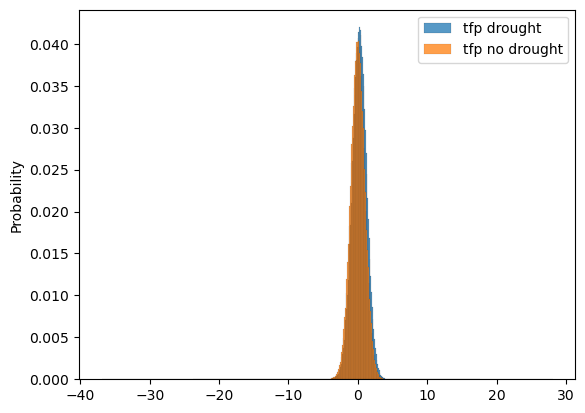

Southern Asia


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Southern Asia = -0.68
Causal effect of drought on tfp is 274.1% [-10575.2%,10336.1%] of the effect of temperature on tfp


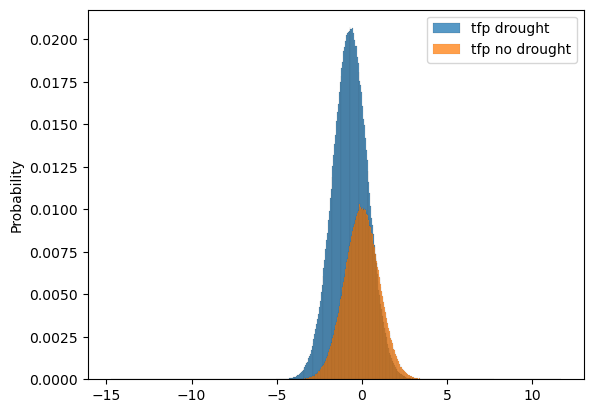

Eastern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limita

/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x16AA51620>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


Estimated ATE for Eastern Europe = -0.74
Causal effect of drought on tfp is 117.9% [-4888.6%,6378.4%] of the effect of temperature on tfp


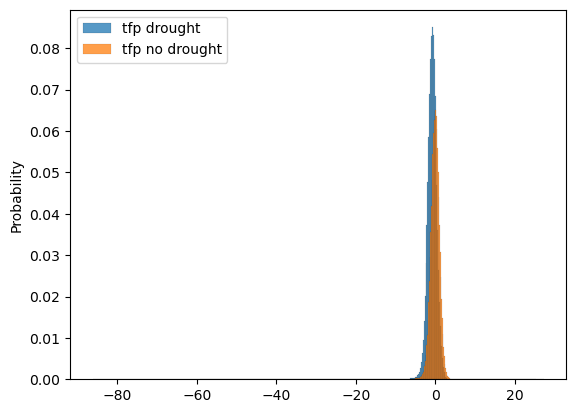

Western Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Western Europe = -0.11
Causal effect of drought on tfp is -1068.0% [-1366.3%,1246.8%] of the effect of temperature on tfp


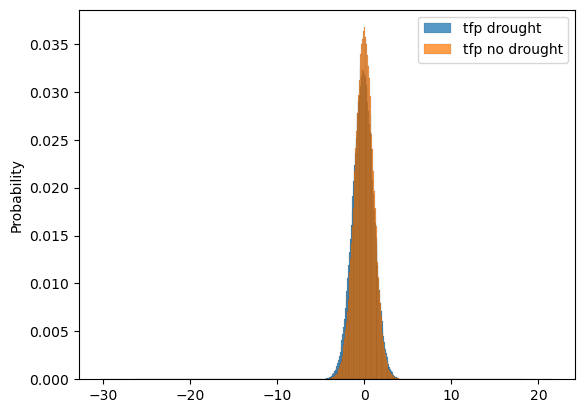

Southern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Southern Europe = -0.35
Causal effect of drought on tfp is -1523.2% [-3779.4%,3600.7%] of the effect of temperature on tfp


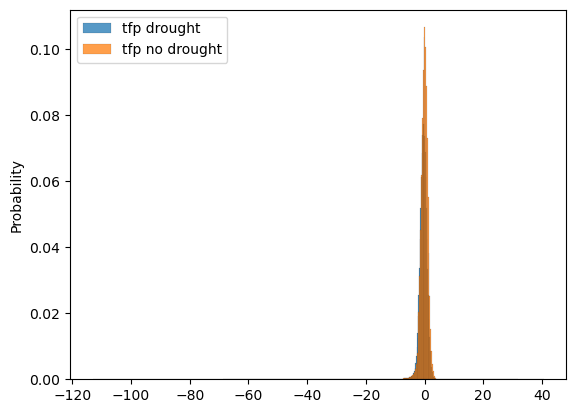

Caribbean


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Caribbean = -0.23
Causal effect of drought on tfp is -1052.3% [-7697.5%,8653.2%] of the effect of temperature on tfp


KeyboardInterrupt: 

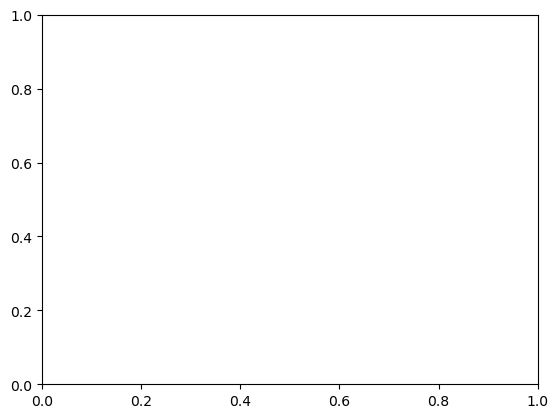

In [40]:
for region, data in data_by_region.items():
    print(region)

    # Normalize data
    temp_scaler, precip_scaler, tfp_scaler = StandardScaler(), MinMaxScaler(), StandardScaler()
    normalized_temp = temp_scaler.fit_transform(np.array(data["Unweighted_Temp"]).reshape(-1,1)).flatten()
    normalized_precip = precip_scaler.fit_transform(np.array(data["Precipitation"]).reshape(-1,1)).flatten()
    normalized_tfp = tfp_scaler.fit_transform(np.array(data["ln_TFP_Change"]).reshape(-1,1)).flatten()
    
    with pm.Model() as model:
    
        temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
        temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
        temp_std = pm.HalfNormal("temp_std", 1, shape=3)
        temp_posterior = pm.NormalMixture(
            "temp_posterior", 
            temp_mw, 
            temp_prior, 
            temp_std,
            observed=normalized_temp
        )
        precip_prior = pm.HalfNormal("precip_prior", 1)
        precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=normalized_precip)
        drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
        drought_likelihood_coefs = pm.Deterministic(
            "drought_likelihood_coefs", 
            pt.transpose(
                pm.math.stack(
                    [
                         (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                         (drought_coefs[1] * np.ones(len(normalized_temp))) + (drought_coefs[3] * np.ones(len(normalized_temp)))
                    ]
                )
            )
        )
        drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
        drought_posterior = pm.Categorical("drought_posterior", drought_prior)
        temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
        temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
        precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
        precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
        drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
        tfp_intercept = pm.Normal('tfp_intercept',0,10)
        tfp_prior = pm.Deterministic(
            "tfp_prior",
            tfp_intercept +
            (temp_tfp_coef * temp_posterior) +
            (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
            (precip_tfp_coef * precip_posterior) +
            (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
            (drought_tfp_coef * drought_posterior)
        )
        tfp_std = pm.HalfNormal('tfp_std', sigma=10)
        tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)
    
    no_drought_model = do(model, {"drought_posterior": np.zeros(len(normalized_temp), dtype="int32")})
    drought_model = do(model, {"drought_posterior": np.ones(len(normalized_temp), dtype="int32")})

    # load regional model from pkl
    regional_trace = pd.read_pickle(f"../models/regional_models/temp_precip_drought_tfp_{region}.pkl")["trace"]
    
    no_drought_tfp_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=no_drought_model,
        var_names=["tfp_posterior"]
    )
    drought_tfp_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=drought_model,
        var_names=["tfp_posterior"]
    )
    
    ATE_est = drought_tfp_samples.posterior_predictive - no_drought_tfp_samples.posterior_predictive
    print(f"Estimated ATE for {region} = {ATE_est.tfp_posterior.mean().values:.2f}")

    percent = (regional_trace.posterior["drought_tfp_coef"] / regional_trace.posterior["temp_tfp_coef"]) * 100
    print(
        f"Causal effect of drought on tfp is {percent.mean():.1f}% [{az.hdi(percent).x.data[0]:.1f}%,{az.hdi(percent).x.data[1]:.1f}%] of the effect of temperature on tfp"
    )
    
    fig, ax = plt.subplots()
    sns.histplot(data=np.array(drought_tfp_samples.posterior_predictive.tfp_posterior).flatten(), stat='probability', bins=500, ax=ax, label="tfp drought")
    sns.histplot(data=np.array(no_drought_tfp_samples.posterior_predictive.tfp_posterior).flatten(), stat='probability', bins=500, ax=ax, label="tfp no drought")
    ax.legend()
    plt.show()